In [ ]:
!pip install -U albumentations
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.2 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt

In [ ]:
train_dataset = load_dataset("sayakpaul/nyu_depth_v2", split="train")

In [3]:
#How many images you want to data preprocess
num_images = 2000

# Data visualization

In [ ]:
#This is for depth map visualization
cmap = plt.cm.viridis

def colored_depthmap(depth, d_min, d_max):
    depth_relative = (depth - d_min) / (d_max - d_min)
    return 255 * cmap(depth_relative)[:,:,:3]

In [ ]:
#This is for storing visualization
for i in range(num_images):
    #Store the image
    image = train_dataset[i]['image']
    image = np.array(image)
    np.save(f'/content/data/image/image_{i}.npy', image)

    #Store the depth map
    depth_map = train_dataset[i]['depth_map']
    depth_map = np.array(depth_map)
    np.save(f'/content/data/depth_map/depth_map_{i}.npy', depth_map)

    #Store the depth map visualization
    depth_map_visualization = train_dataset[i]['depth_map']
    depth_map_visualization = np.array(depth_map_visualization)

    d_min = np.min(depth_map_visualization)
    d_max = np.max(depth_map_visualization)

    depth_map_visualization = colored_depthmap(depth_map_visualization, d_min, d_max)
    depth_map_visualization = depth_map_visualization.astype("uint8")
    np.save(f'/content/data/depth_map_visualization/depth_map_visualization_{i}.npy', depth_map_visualization)

# Data augmentation

In [ ]:
import random

In [ ]:
class RandomHorizontalFlip:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img1, img2):
        random_num = random.randint(0, 1)
        if random_num == 1:
            return np.fliplr(img1), np.fliplr(img2)
        return img1, img2

In [ ]:
class RandomCrop:
    def __init__(self, height, width):
        self.height = height
        self.width = width

    def __call__(self, img1, img2):
        image_height = img1.shape[0]
        image_width = img1.shape[1]

        max_y = image_height-self.height
        max_x = image_width-self.width

        starting_y = random.randint(0, max_y)
        starting_x = random.randint(0, max_x)

        cropped_img1 = img1[starting_y:starting_y+self.height, starting_x:starting_x+self.width, :]
        cropped_img2 = img2[starting_y:starting_y+self.height, starting_x:starting_x+self.width]
        return cropped_img1, cropped_img2

In [ ]:
randomly_flipping = RandomHorizontalFlip()
randomly_crop = RandomCrop(240, 320)

In [ ]:
!mkdir "/content/drive/MyDrive/APS360_Group/data/augmented_image"
!mkdir "/content/drive/MyDrive/APS360_Group/data/augmented_depth_map"

In [ ]:
import os

file_path_to_image = "/content/drive/MyDrive/APS360_Group/data/image"
file_path_to_depth_map = "/content/drive/MyDrive/APS360_Group/data/depth_map"

for i in range(num_images):
    image_file_name = "image_"+str(i)+".npy"
    depth_map_file_name = "depth_map_"+str(i)+".npy"

    image_file_path = os.path.join(file_path_to_image, image_file_name)
    depth_file_path = os.path.join(file_path_to_depth_map, depth_map_file_name)

    numpy_image = np.load(image_file_path)
    numpy_depth_map = np.load(depth_file_path)

    numpy_image, numpy_depth_map = randomly_flipping(numpy_image, numpy_depth_map)
    numpy_image, numpy_depth_map = randomly_crop(numpy_image, numpy_depth_map)

    #Store the augmented images
    np.save(f'/content/drive/MyDrive/APS360_Group/data/augmented_image/augmented_image_{i}.npy', numpy_image)

    #Store the augmented depth map
    np.save(f'/content/drive/MyDrive/APS360_Group/data/augmented_depth_map/augmented_depth_map_{i}.npy', numpy_depth_map)

# Data preprocess for sampling

In [ ]:
import os

os.chdir("/content/drive/MyDrive/APS360_Group/data")
os.mkdir("augmented_depth_map_max_pool")

In [ ]:
os.chdir("augmented_depth_map")
list_of_depth_maps = os.listdir()
os.chdir("..")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.measure

file_path_to_depth_map = "/content/drive/MyDrive/APS360_Group/data/augmented_depth_map"
file_path_to_sampled_depth_map = "/content/drive/MyDrive/APS360_Group/data/augmented_depth_map_max_pool"

for file in list_of_depth_maps:
    source = os.path.join(file_path_to_depth_map, file)
    depth_map = np.load(source)
    depth_map = skimage.measure.block_reduce(depth_map, (4,4), np.max)
    destination = os.path.join(file_path_to_sampled_depth_map, file)
    np.save(destination, depth_map)

# Create dataloader

In [16]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

image_list = []
depth_map_pooled_list = []
depth_map_list = []

for i in range(num_images):
    image = np.load(f'/content/drive/MyDrive/APS360_Group/data/Depth Estimation/augmented_image/augmented_image_{i}.npy')
    image = torch.tensor(image)
    image = image.transpose(1, 2).transpose(0, 1)
    depth_map_pooled = np.load(f'/content/drive/MyDrive/APS360_Group/data/Depth Estimation/augmented_depth_map_max_pool/augmented_depth_map_{i}.npy')
    depth_map_pooled = torch.tensor(depth_map_pooled)
    depth_map = np.load(f'/content/drive/MyDrive/APS360_Group/data/Depth Estimation/augmented_depth_map/augmented_depth_map_{i}.npy')
    depth_map = torch.tensor(depth_map)

    image_list.append(image)
    depth_map_pooled_list.append(depth_map_pooled)
    depth_map_list.append(depth_map)
    print(i)

image_tensor = torch.stack(image_list)
depth_map_pooled_tensor = torch.stack(depth_map_pooled_list)
depth_map_tensor = torch.stack(depth_map_list)

dataset = TensorDataset(image_tensor, depth_map_pooled_tensor, depth_map_tensor)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [17]:
import pickle

# Store TensorDataset
with open('depth_estimatioin.pkl', 'wb') as f:
    pickle.dump(dataset, f)

In [20]:
# Load TensorDataset
with open('depth_estimatioin.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [23]:
batch_size = 32  # Set your batch size
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# If you want to visualize any data

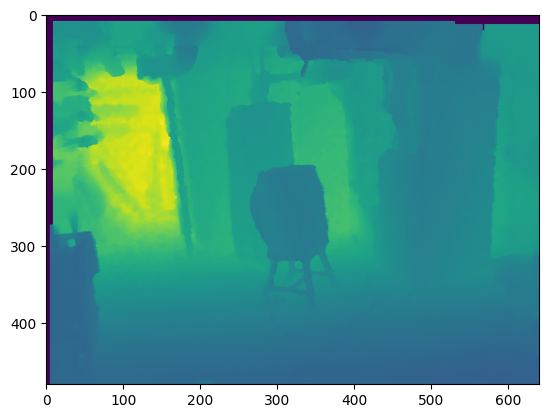

In [ ]:
#Load the file you want to visualize
array = np.load("/content/data/depth_map_visualization/depth_map_visualization_100.npy")
plt.imshow(array)